# Data Preparation untuk Customer Service Chatbot

Notebook ini akan memproses dan menganalisis data untuk training chatbot customer service. Proses meliputi:
1. Loading data dari YAML files
2. Text preprocessing
3. Analisis dan visualisasi data
4. Persiapan data untuk training

In [14]:
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections.abc
collections.Hashable = collections.abc.Hashable


# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Atur gaya Seaborn untuk visualisasi
sns.set()  # Gaya visualisasi Seaborn
sns.set_palette("husl")  # Palet warna

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/muhammadkhalidalghifari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/muhammadkhalidalghifari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def get_project_root():
    """Get the project root directory."""
    # Sesuaikan dengan struktur folder Anda
    current_dir = os.getcwd()  # Dapatkan direktori saat ini
    return current_dir

def load_data_with_path():
    # Dapatkan path root proyek
    project_root = get_project_root()
    
    # Construct path to data directory
    base_path = os.path.join(project_root, "chatterbot_corpus", "data")
    print(f"Looking for data in: {base_path}")
    
    # Verifikasi path
    if not os.path.exists(base_path):
        print(f"ERROR: Data directory not found at {base_path}")
        print("Please check if the path is correct and the data directory exists")
        return None
    
    print("\nStarting data loading process...")
    return load_all_data(base_path)

# Load data
print("Initializing data loading...")
df = load_data_with_path()

if df is not None and len(df) > 0:
    # Split data and continue with training
    from sklearn.model_selection import train_test_split
    
    # Split into train and test first
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    # Split train into train and validation
    train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
    
    print("\nData split sizes:")
    print(f"Training set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")

Initializing data loading...
Looking for data in: /Users/muhammadkhalidalghifari/Library/Mobile Documents/com~apple~CloudDocs/AI/CHATBOT/notebooks/chatterbot_corpus/data
ERROR: Data directory not found at /Users/muhammadkhalidalghifari/Library/Mobile Documents/com~apple~CloudDocs/AI/CHATBOT/notebooks/chatterbot_corpus/data
Please check if the path is correct and the data directory exists


## 1. Data Loading

In [ ]:
def load_yaml_file(file_path):
    """Load single YAML file and extract conversations."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = yaml.safe_load(file)
            
            if not data or 'conversations' not in data:
                print(f"No conversations found in {file_path}")
                return []
            
            # Get category from YAML data
            category = data.get('categories', ['uncategorized'])[0]
            conversations = data['conversations']
            
            qa_pairs = []
            for conversation in conversations:
                if isinstance(conversation, list) and len(conversation) >= 2:
                    qa_pairs.append({
                        'question': conversation[0],
                        'answer': conversation[1],
                        'category': category
                    })
            
            print(f"Loaded {len(qa_pairs)} QA pairs from {os.path.basename(file_path)}")
            return qa_pairs
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return []

def load_all_data(base_path):
    """Load all YAML files recursively."""
    all_qa_pairs = []
    
    # Pastikan path ada
    if not os.path.exists(base_path):
        print(f"Path not found: {base_path}")
        return pd.DataFrame()
    
    # Load semua file YAML
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(('.yml', '.yaml')):
                file_path = os.path.join(root, file)
                print(f"\nProcessing: {file}")
                qa_pairs = load_yaml_file(file_path)
                all_qa_pairs.extend(qa_pairs)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_qa_pairs)
    
    if len(df) > 0:
        print(f"\nTotal QA pairs loaded: {len(df)}")
        print(f"Columns: {df.columns.tolist()}")
        print("\nSample data:")
        print(df.head(2))
    else:
        print("\nNo data loaded!")
        
    return df

Loading data from all languages...
Path not found: chatterbot_corpus/data/indonesian


## 2. Data Analysis & Visualization

In [27]:
def analyze_data_distribution(df):
    """Analyze and visualize data distribution."""
    if len(df) == 0:
        print("No data to analyze!")
        return
    
    # Buat figure dengan ukuran yang sesuai
    plt.figure(figsize=(15, 12))
    
    # Plot 1: Distribution by category
    plt.subplot(2, 2, 1)
    sns.countplot(data=df, y='category')
    plt.title('Distribution of QA Pairs by Category', pad=20)
    plt.xlabel('Number of Pairs')
    
    # Plot 2: Question length distribution
    plt.subplot(2, 2, 2)
    df['question_length'] = df['question'].str.len()
    sns.histplot(data=df, x='question_length', bins=30)
    plt.title('Question Length Distribution', pad=20)
    plt.xlabel('Number of Characters')
    
    # Plot 3: Answer length distribution
    plt.subplot(2, 2, 3)
    df['answer_length'] = df['answer'].str.len()
    sns.histplot(data=df, x='answer_length', bins=30)
    plt.title('Answer Length Distribution', pad=20)
    plt.xlabel('Number of Characters')
    
    # Plot 4: Question vs Answer length
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=df, x='question_length', y='answer_length', alpha=0.5)
    plt.title('Question vs Answer Length', pad=20)
    plt.xlabel('Question Length (characters)')
    plt.ylabel('Answer Length (characters)')
    
    # Adjust layout
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Print statistics
    print("\nDataset Statistics:")
    print("-" * 50)
    print(f"Total QA Pairs: {len(df)}")
    print(f"Number of Categories: {len(df['category'].unique())}")
    print("\nCategory Distribution:")
    print(df['category'].value_counts())
    print("\nLength Statistics:")
    print("\nQuestions:")
    print(df['question_length'].describe().round(2))
    print("\nAnswers:")
    print(df['answer_length'].describe().round(2))

# Set the correct path
base_path = "/Users/muhammadkhalidalghifari/Library/Mobile Documents/com~apple~CloudDocs/AI/CHATBOT/chatterbot_corpus/data/indonesian"

# Load and analyze data
print("Loading data from:", base_path)
df = load_all_data(base_path)

if len(df) > 0:
    print("\nAnalyzing data distribution...")
    analyze_data_distribution(df)

Loading data from: /Users/muhammadkhalidalghifari/Library/Mobile Documents/com~apple~CloudDocs/AI/CHATBOT/chatterbot_corpus/data/indonesian

No data loaded!


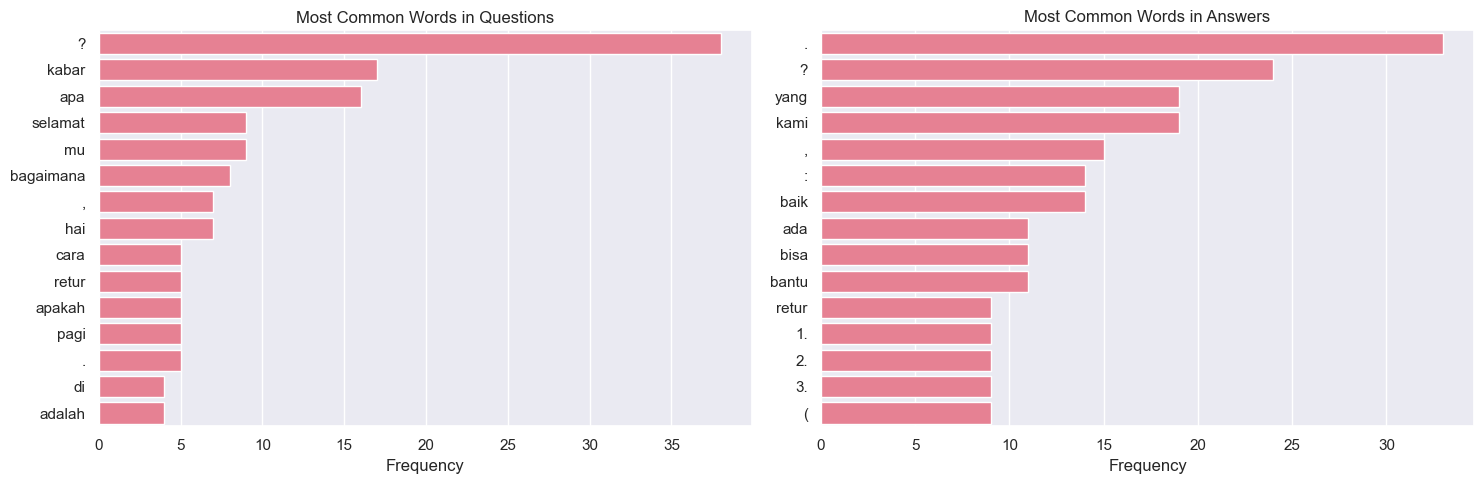

In [22]:
def analyze_word_frequencies(df):
    """Analyze and visualize word frequencies."""
    def get_word_freq(texts):
        words = []
        for text in texts:
            words.extend(word_tokenize(text.lower()))
        return Counter(words)
    
    # Get frequencies
    question_freq = get_word_freq(df['question'])
    answer_freq = get_word_freq(df['answer'])
    
    # Plot
    plt.figure(figsize=(15, 5))
    
    # Questions word frequency
    plt.subplot(1, 2, 1)
    words, counts = zip(*question_freq.most_common(15))
    sns.barplot(x=list(counts), y=list(words))
    plt.title('Most Common Words in Questions')
    plt.xlabel('Frequency')
    
    # Answers word frequency
    plt.subplot(1, 2, 2)
    words, counts = zip(*answer_freq.most_common(15))
    sns.barplot(x=list(counts), y=list(words))
    plt.title('Most Common Words in Answers')
    plt.xlabel('Frequency')
    
    plt.tight_layout()
    plt.show()

analyze_word_frequencies(df)

## 3. Text Preprocessing

In [23]:
def preprocess_text(text):
    """Preprocess text for training."""
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters but keep essential punctuation
    text = re.sub(r'[^\w\s.,?!]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing
df['processed_question'] = df['question'].apply(preprocess_text)
df['processed_answer'] = df['answer'].apply(preprocess_text)

# Show sample of processed data
print("Sample of processed data:")
print(df[['question', 'processed_question', 'answer', 'processed_answer']].head())

Sample of processed data:
                       question            processed_question  \
0                    Cara retur                    cara retur   
1          Bagaimana cara retur          bagaimana cara retur   
2    Cara mengemas barang retur    cara mengemas barang retur   
3      Berapa lama proses retur      berapa lama proses retur   
4  Biaya retur ditanggung siapa  biaya retur ditanggung siapa   

                                              answer  \
0  Untuk retur barang, silakan ikuti langkah beri...   
1  Untuk retur barang, silakan ikuti langkah beri...   
2  Panduan mengemas barang retur:\n1. Gunakan kem...   
3  Proses retur membutuhkan waktu 3-5 hari kerja ...   
4  Ketentuan biaya retur:\n1. Kesalahan produk/pe...   

                                    processed_answer  
0  untuk retur barang, silakan ikuti langkah beri...  
1  untuk retur barang, silakan ikuti langkah beri...  
2  panduan mengemas barang retur 1. gunakan kemas...  
3  proses retur membutuhka

## 4. Data Splitting

Training set size: 61
Validation set size: 7
Test set size: 8


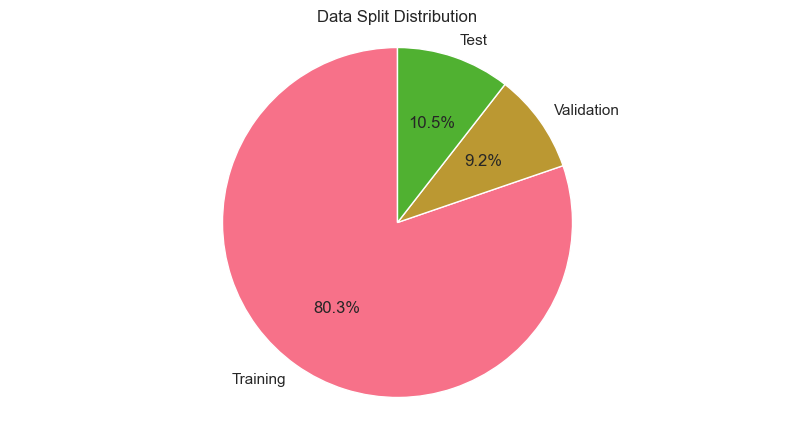

In [24]:
from sklearn.model_selection import train_test_split

# First split: separate test set
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Second split: separate validation set from training
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Visualize split distribution
plt.figure(figsize=(10, 5))
splits = ['Training', 'Validation', 'Test']
sizes = [len(train_df), len(val_df), len(test_df)]

plt.pie(sizes, labels=splits, autopct='%1.1f%%', startangle=90)
plt.title('Data Split Distribution')
plt.axis('equal')
plt.show()

## 5. Save Processed Data

In [25]:
# Create processed data directory if it doesn't exist
os.makedirs('data/processed', exist_ok=True)

# Save processed datasets
train_df.to_csv('data/processed/train.csv', index=False)
val_df.to_csv('data/processed/validation.csv', index=False)
test_df.to_csv('data/processed/test.csv', index=False)

print("Data saved successfully!")

Data saved successfully!
